In [ ]:
#!pip install --upgrade tensorflow

In [ ]:
import pandas as pd
import numpy as np

#import torch
#import torchvision.transforms as transforms
#from torchvision import datasets
#from torch.utils.data import random_split, DataLoader, Dataset
#import torch.optim as optim
#import torch.nn as nn
#import torch.nn.functional as F

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers,ops, losses, metrics, optimizers
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight


import matplotlib.pyplot as plt

import seaborn as sns

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
play_path = '/content/drive/Shareddrives/461 Project/nfl-big-data-bowl-2025/plays.csv'

In [ ]:
plays_df = pd.read_csv(play_path)

df2 = plays_df

In [ ]:
df2.head()

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,...,yardsGained,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPointsAdded,isDropback,pff_runConceptPrimary,pff_runConceptSecondary,pff_runPassOption,pff_passCoverage,pff_manZone
0,2022102302,2655,(1:54) (Shotgun) J.Burrow pass short middle to...,3,1,10,CIN,ATL,CIN,21,...,9,0.004634,-0.004634,0.702717,True,NaN,NaN,0,Cover-3,Zone
1,2022091809,3698,(2:13) (Shotgun) J.Burrow pass short right to ...,4,1,10,CIN,DAL,CIN,8,...,4,0.002847,-0.002847,-0.240509,True,NaN,NaN,0,Quarters,Zone
2,2022103004,3146,(2:00) (Shotgun) D.Mills pass short right to D...,4,3,12,HOU,TEN,HOU,20,...,6,0.000205,-0.000205,-0.218480,True,NaN,NaN,0,Quarters,Zone
3,2022110610,348,(9:28) (Shotgun) P.Mahomes pass short left to ...,1,2,10,KC,TEN,TEN,23,...,4,-0.001308,0.001308,-0.427749,True,NaN,NaN,0,Quarters,Zone
4,2022102700,2799,(2:16) (Shotgun) L.Jackson up the middle to TB...,3,2,8,BAL,TB,TB,27,...,-1,0.027141,-0.027141,-0.638912,False,MAN,READ OPTION,0,Cover-1,Man


### Exploratory Data Analysis

In [ ]:
plays_df['pff_manZone'].unique()

array(['Zone', 'Man', nan, 'Other'], dtype=object)

In [ ]:
df2['pff_manZone'].value_counts()

,count
pff_manZone,
Zone,10969
Man,4145
Other,818


([<matplotlib.patches.Wedge at 0x7f250dee6680>,
 [Text(-0.6139649083854941, 0.9127141344754073, 'Zone'),
  Text(0.45941267209621056, -0.9994698578333515, 'Man'),
  Text(1.0857214073673263, -0.1766607641337277, 'Other')])

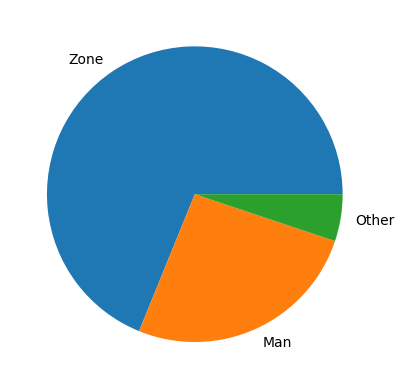

In [ ]:
# create pie chart of pff_manZone
plt.pie(plays_df['pff_manZone'].value_counts(), labels=plays_df['pff_manZone'].value_counts().index)

<Axes: xlabel='gameId', ylabel='pff_manZone'>

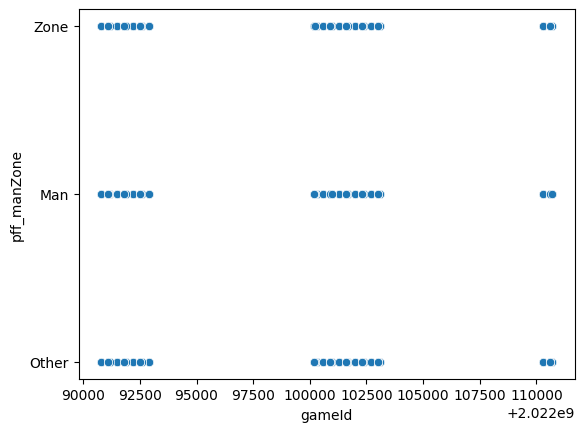

In [ ]:
sns.scatterplot(data = plays_df, x = 'gameId', y = 'pff_manZone')

<Axes: xlabel='playNullifiedByPenalty', ylabel='pff_manZone'>

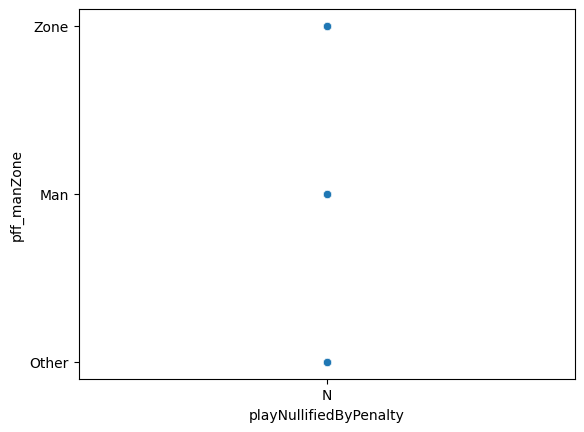

In [ ]:
sns.scatterplot(data = plays_df, x = 'playNullifiedByPenalty', y = 'pff_manZone')

<Axes: xlabel='pff_passCoverage', ylabel='pff_manZone'>

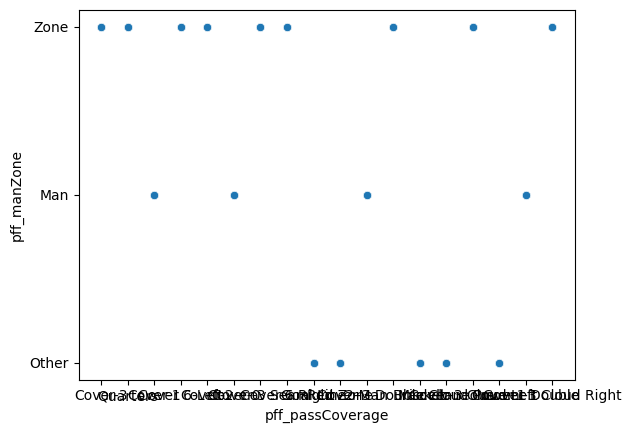

In [ ]:
import seaborn as sns
sns.scatterplot(data = plays_df, x = 'pff_passCoverage', y = 'pff_manZone')

In [ ]:
plays_df['playDescription'].unique()

array(['(1:54) (Shotgun) J.Burrow pass short middle to T.Boyd to CIN 30 for 9 yards (J.Hawkins).',
       '(2:13) (Shotgun) J.Burrow pass short right to H.Hurst to CIN 12 for 4 yards (L.Vander Esch).',
       '(2:00) (Shotgun) D.Mills pass short right to D.Pierce to HST 26 for 6 yards (D.Walker).',
       ...,
       '(9:59) (Shotgun) P.Mahomes scrambles right end to IND 3 for 10 yards (R.Thomas).',
       '(:45) C.Rush pass incomplete deep right to C.Lamb.',
       '(15:00) Br.Hall up the middle for 34 yards, TOUCHDOWN.'],
      dtype=object)

## Data Cleaning

### Drop na values of pff_manZone since we are only interested in classified rows


In [ ]:
df2 = df2.dropna(subset=['pff_manZone'])

### Split Game Clock to minutes and seconds columns so can be read as an integer

In [ ]:
# convert gameClock to string
df2['gameClock'] = df2['gameClock'].astype(str)

# split gameClock by : (original format = MM:SS)
df2[['gameMin','gameSec']] = df2['gameClock'].str.split(':', n=1, expand=True)

# Drop the original 'gameClock' column not needed
df2 = df2.drop('gameClock', axis=1)

# convert gameMin and gameSec to int so more easily interpreted
df2['gameMin'] = df2['gameMin'].astype(int)
df2['gameSec'] = df2['gameSec'].astype(int)

<ipython-input-17-6a3f5eb51273>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['gameClock'] = df2['gameClock'].astype(str)
<ipython-input-17-6a3f5eb51273>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[['gameMin','gameSec']] = df2['gameClock'].str.split(':', n=1, expand=True)
<ipython-input-17-6a3f5eb51273>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

### Drop unimportant columns that will make noise in data
- drop gameID, this should be unimportant
- drop playDescription since it is a sentence and will be hard to encode for the neural network to understand
- drop yardlineSide is arbitrary.
- drop playNullifiedByPenalty since only No values are included (there is no man or zone classification if Yes)
- pff_manZone is a broader category of pff_passCoverage so if this variable is known then so is pff_manZone


In [ ]:
df2.drop(['gameId','playDescription','pff_passCoverage', 'playNullifiedByPenalty'], axis=1, inplace=True)

## Preprocessing

### Categorical Preprocessing

In [ ]:
def preprocess_categorical_data(df):
  # Select categorical columns
  cat_cols = df.select_dtypes(include=['object']).columns
  # Make nan for categorical = 'missing'
  for column in df.select_dtypes(include=['object']):
    df[column] = df[column].fillna('missing')
  # Convert object to string
  for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype(str)
  # Get categorical column names
  categorical_feature_names = np.asarray(cat_cols)
  return df, categorical_feature_names

### Numeric Preprocessing

In [ ]:
def preprocess_numeric_data(df):
  # Select numeric columns
  num_cols = df.select_dtypes(include=['int64', 'float64']).columns
  # Make nan for numeric = 0
  for column in df.select_dtypes(include=['int64', 'float64']):
    df[column] = df[column].fillna(0)
  # Convert numeric to float
  for col in df.select_dtypes(include=['int64', 'float64']).columns:
    df[col] = df[col].astype(float)  # Convert to float
  # Get numeric column names
  numeric_feature_names = np.asarray(num_cols)
  return df, numeric_feature_names

### Binary Preprocessing

In [ ]:
def preprocess_binary_data(df):
  # Select binary columns
  binary_cols = df.select_dtypes(include=['bool']).columns
  # Convert binary from bool to int
  for col in df.select_dtypes(include=['bool']).columns:
    df[col] = df[col].astype(int)  # Convert True to 1, False to 0
  # Get binary column names
  binary_feature_names = np.asarray(binary_cols)
  return df, binary_feature_names

#### Create empty for inputs and preprocessed to be used in feature transformation

### Convert Categorical values string and send to inputs

In [ ]:
def categorical_input(df,inputs):
  # Convert categorical values to TensorFlow string
  for name, column in df.items():
    if (name in categorical_feature_names):
      dtype = tf.string
    # Convert rest to TensorFrflow float
    else:
      dtype = tf.float32
    inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)
  return inputs

### Categorical Feature names to preprocesed

In [ ]:
def categorical_features(categorical_feature_names, df, inputs, preprocessed):
  for name in categorical_feature_names:
    # get different category names for each feature
    vocab = sorted(set(str(x) for x in df[name]))
    print(f'name: {name}')
    print(f'vocab: {vocab}\n')
    # Onehot encode category names to convert to numeric if string
    if type(vocab[0]) is str:
      lookup = tf.keras.layers.StringLookup(vocabulary=vocab, output_mode='one_hot')
    # If not string convert to string then one hot encode
    else:
      inputs[vocab] = tf.strings.as_string(inputs[vocab])
      lookup = tf.keras.layers.IntegerLookup(vocabulary=vocab, output_mode='one_hot')
    # add to preprocessed list
    x = inputs[name]
    x = lookup(x)
    preprocessed.append(x)

  return preprocessed

### Binary Feature names to preprocessed

In [ ]:
def binary_features(binary_feature_names, inputs, preprocessed):
  # Since binary features were already converted to numeric then float we can just add to input list
  for name in binary_feature_names:
    inp = inputs[name]
    preprocessed.append(inp)
  return preprocessed

### Numeric Features to preprocessed

In [ ]:
def numeric_features(numeric_feature_names, df, inputs, preprocessed):
  # get numeric features from dataframe
  num_features = df[numeric_feature_names]
  # convert from numpy to tensor
  tf.convert_to_tensor(num_features)
  # use indicies to avoid data mismatching
  num_features_dict = {key: value.to_numpy()[:, tf.newaxis] for key, value in dict(num_features).items()}
  # modify target axis to TensorFlow axis
  target_array =  target[:, tf.newaxis]

  # Normalize the data
  normalizer = tf.keras.layers.Normalization(axis=-1)
  normalizer.adapt(np.concatenate([value for key, value in sorted(num_features_dict.items())], axis=1))

  # create empty list of numeric inputs then populate
  numeric_inputs = []
  for name in numeric_feature_names:
    numeric_inputs.append(inputs[name])

  # make sure all numeric inputs are stored in the list
  numeric_inputs = tf.keras.layers.Concatenate(axis=-1)(numeric_inputs)
  # normalize again
  numeric_normalized = normalizer(numeric_inputs)
  # add numeric to preprocessed
  preprocessed.append(numeric_normalized)

  return preprocessed

### Concatenate Preprocessed data

In [ ]:
def concat_prepro(preprocessed, inputs):
  # Concatenate preprocessed data across data types
  preprocessed_result = tf.keras.layers.Concatenate(axis=1)(preprocessed)
  print(preprocessed_result)
  # Create preprocesssing model
  preprocessor = tf.keras.Model(inputs, preprocessed_result)
  print(preprocessor)
  # plot the model
  model_plot = tf.keras.utils.plot_model(preprocessor, rankdir="LR", show_shapes=True,  show_layer_names=True)
  return preprocessor, model_plot

## Split data into training, testing, and validation

### Set pff_manZone as target and encode since categorical

In [ ]:
target = df2.pop('pff_manZone')
onehot_encoder = OneHotEncoder(sparse_output=False)
target = onehot_encoder.fit_transform(target.values.reshape(-1, 1))

In [ ]:
X = df2
y = target

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(11152, 46)
(2390, 46)
(2390, 46)
(11152, 3)
(2390, 3)
(2390, 3)


## Implement preprocessing

In [ ]:
inputs = {}
preprocessed = []

###Preprocess Categorical data

#### Train

In [ ]:
train_inputs = {}
train_preprocessed = []

In [ ]:
X_train, categorical_feature_names = preprocess_categorical_data(X_train)

In [ ]:
train_inputs = categorical_input(X_train, train_inputs)
train_inputs

{'playId': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=playId>,
 'quarter': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=quarter>,
 'down': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=down>,
 'yardsToGo': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=yardsToGo>,
 'possessionTeam': <KerasTensor shape=(None, 1), dtype=string, sparse=False, name=possessionTeam>,
 'defensiveTeam': <KerasTensor shape=(None, 1), dtype=string, sparse=False, name=defensiveTeam>,
 'yardlineSide': <KerasTensor shape=(None, 1), dtype=string, sparse=False, name=yardlineSide>,
 'yardlineNumber': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=yardlineNumber>,
 'preSnapHomeScore': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=preSnapHomeScore>,
 'preSnapVisitorScore': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=preSnapVisitorScore>,
 'absoluteYardlineNumber': <KerasTensor shape=(None, 1)

In [ ]:
train_preprocessed = categorical_features(categorical_feature_names, X_train, train_inputs, train_preprocessed)
train_preprocessed

name: possessionTeam
vocab: ['ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE', 'DAL', 'DEN', 'DET', 'GB', 'HOU', 'IND', 'JAX', 'KC', 'LA', 'LAC', 'LV', 'MIA', 'MIN', 'NE', 'NO', 'NYG', 'NYJ', 'PHI', 'PIT', 'SEA', 'SF', 'TB', 'TEN', 'WAS']

name: defensiveTeam
vocab: ['ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE', 'DAL', 'DEN', 'DET', 'GB', 'HOU', 'IND', 'JAX', 'KC', 'LA', 'LAC', 'LV', 'MIA', 'MIN', 'NE', 'NO', 'NYG', 'NYJ', 'PHI', 'PIT', 'SEA', 'SF', 'TB', 'TEN', 'WAS']

name: yardlineSide
vocab: ['ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE', 'DAL', 'DEN', 'DET', 'GB', 'HOU', 'IND', 'JAX', 'KC', 'LA', 'LAC', 'LV', 'MIA', 'MIN', 'NE', 'NO', 'NYG', 'NYJ', 'PHI', 'PIT', 'SEA', 'SF', 'TB', 'TEN', 'WAS', 'missing']

name: offenseFormation
vocab: ['EMPTY', 'I_FORM', 'JUMBO', 'PISTOL', 'SHOTGUN', 'SINGLEBACK', 'WILDCAT', 'missing']

name: receiverAlignment
vocab: ['1x0', '1x1', '2x0', '2x1', '2x2', '3x0', '3x1', '3x2', '4x1', '4x2', 'missing']

name: passResult
vocab:

[<KerasTensor shape=(None, 33), dtype=float32, sparse=False, name=keras_tensor>,
 <KerasTensor shape=(None, 33), dtype=float32, sparse=False, name=keras_tensor_1>,
 <KerasTensor shape=(None, 34), dtype=float32, sparse=False, name=keras_tensor_2>,
 <KerasTensor shape=(None, 9), dtype=float32, sparse=False, name=keras_tensor_3>,
 <KerasTensor shape=(None, 12), dtype=float32, sparse=False, name=keras_tensor_4>,
 <KerasTensor shape=(None, 7), dtype=float32, sparse=False, name=keras_tensor_5>,
 <KerasTensor shape=(None, 11), dtype=float32, sparse=False, name=keras_tensor_6>,
 <KerasTensor shape=(None, 6), dtype=float32, sparse=False, name=keras_tensor_7>,
 <KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_8>,
 <KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_9>,
 <KerasTensor shape=(None, 3), dtype=float32, sparse=False, name=keras_tensor_10>,
 <KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_11>,
 <KerasTens

#### Validation

In [ ]:
val_inputs = {}
val_preprocessed = []

In [ ]:
X_val, categorical_feature_names = preprocess_categorical_data(X_val)

In [ ]:
val_inputs = categorical_input(X_val, val_inputs)
val_inputs

{'playId': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=playId>,
 'quarter': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=quarter>,
 'down': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=down>,
 'yardsToGo': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=yardsToGo>,
 'possessionTeam': <KerasTensor shape=(None, 1), dtype=string, sparse=False, name=possessionTeam>,
 'defensiveTeam': <KerasTensor shape=(None, 1), dtype=string, sparse=False, name=defensiveTeam>,
 'yardlineSide': <KerasTensor shape=(None, 1), dtype=string, sparse=False, name=yardlineSide>,
 'yardlineNumber': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=yardlineNumber>,
 'preSnapHomeScore': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=preSnapHomeScore>,
 'preSnapVisitorScore': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=preSnapVisitorScore>,
 'absoluteYardlineNumber': <KerasTensor shape=(None, 1)

In [ ]:
val_preprocessed = categorical_features(categorical_feature_names, X_val, val_inputs, val_preprocessed)
val_preprocessed

name: possessionTeam
vocab: ['ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE', 'DAL', 'DEN', 'DET', 'GB', 'HOU', 'IND', 'JAX', 'KC', 'LA', 'LAC', 'LV', 'MIA', 'MIN', 'NE', 'NO', 'NYG', 'NYJ', 'PHI', 'PIT', 'SEA', 'SF', 'TB', 'TEN', 'WAS']

name: defensiveTeam
vocab: ['ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE', 'DAL', 'DEN', 'DET', 'GB', 'HOU', 'IND', 'JAX', 'KC', 'LA', 'LAC', 'LV', 'MIA', 'MIN', 'NE', 'NO', 'NYG', 'NYJ', 'PHI', 'PIT', 'SEA', 'SF', 'TB', 'TEN', 'WAS']

name: yardlineSide
vocab: ['ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE', 'DAL', 'DEN', 'DET', 'GB', 'HOU', 'IND', 'JAX', 'KC', 'LA', 'LAC', 'LV', 'MIA', 'MIN', 'NE', 'NO', 'NYG', 'NYJ', 'PHI', 'PIT', 'SEA', 'SF', 'TB', 'TEN', 'WAS', 'missing']

name: offenseFormation
vocab: ['EMPTY', 'I_FORM', 'JUMBO', 'PISTOL', 'SHOTGUN', 'SINGLEBACK', 'WILDCAT']

name: receiverAlignment
vocab: ['1x1', '2x0', '2x1', '2x2', '3x0', '3x1', '3x2', '3x3', '4x1']

name: passResult
vocab: ['C', 'I', 'IN', 'R', 'S', '

[<KerasTensor shape=(None, 33), dtype=float32, sparse=False, name=keras_tensor_15>,
 <KerasTensor shape=(None, 33), dtype=float32, sparse=False, name=keras_tensor_16>,
 <KerasTensor shape=(None, 34), dtype=float32, sparse=False, name=keras_tensor_17>,
 <KerasTensor shape=(None, 8), dtype=float32, sparse=False, name=keras_tensor_18>,
 <KerasTensor shape=(None, 10), dtype=float32, sparse=False, name=keras_tensor_19>,
 <KerasTensor shape=(None, 7), dtype=float32, sparse=False, name=keras_tensor_20>,
 <KerasTensor shape=(None, 11), dtype=float32, sparse=False, name=keras_tensor_21>,
 <KerasTensor shape=(None, 5), dtype=float32, sparse=False, name=keras_tensor_22>,
 <KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_23>,
 <KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_24>,
 <KerasTensor shape=(None, 3), dtype=float32, sparse=False, name=keras_tensor_25>,
 <KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_26>,

#### Test

In [ ]:
test_inputs = {}
test_preprocessed = []

In [ ]:
X_test, categorical_feature_names = preprocess_categorical_data(X_test)

In [ ]:
test_inputs = categorical_input(X_test, test_inputs)
test_inputs

{'playId': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=playId>,
 'quarter': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=quarter>,
 'down': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=down>,
 'yardsToGo': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=yardsToGo>,
 'possessionTeam': <KerasTensor shape=(None, 1), dtype=string, sparse=False, name=possessionTeam>,
 'defensiveTeam': <KerasTensor shape=(None, 1), dtype=string, sparse=False, name=defensiveTeam>,
 'yardlineSide': <KerasTensor shape=(None, 1), dtype=string, sparse=False, name=yardlineSide>,
 'yardlineNumber': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=yardlineNumber>,
 'preSnapHomeScore': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=preSnapHomeScore>,
 'preSnapVisitorScore': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=preSnapVisitorScore>,
 'absoluteYardlineNumber': <KerasTensor shape=(None, 1)

In [ ]:
test_preprocessed = categorical_features(categorical_feature_names, X_test, test_inputs, test_preprocessed)
test_preprocessed

name: possessionTeam
vocab: ['ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE', 'DAL', 'DEN', 'DET', 'GB', 'HOU', 'IND', 'JAX', 'KC', 'LA', 'LAC', 'LV', 'MIA', 'MIN', 'NE', 'NO', 'NYG', 'NYJ', 'PHI', 'PIT', 'SEA', 'SF', 'TB', 'TEN', 'WAS']

name: defensiveTeam
vocab: ['ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE', 'DAL', 'DEN', 'DET', 'GB', 'HOU', 'IND', 'JAX', 'KC', 'LA', 'LAC', 'LV', 'MIA', 'MIN', 'NE', 'NO', 'NYG', 'NYJ', 'PHI', 'PIT', 'SEA', 'SF', 'TB', 'TEN', 'WAS']

name: yardlineSide
vocab: ['ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE', 'DAL', 'DEN', 'DET', 'GB', 'HOU', 'IND', 'JAX', 'KC', 'LA', 'LAC', 'LV', 'MIA', 'MIN', 'NE', 'NO', 'NYG', 'NYJ', 'PHI', 'PIT', 'SEA', 'SF', 'TB', 'TEN', 'WAS', 'missing']

name: offenseFormation
vocab: ['EMPTY', 'I_FORM', 'JUMBO', 'PISTOL', 'SHOTGUN', 'SINGLEBACK', 'WILDCAT']

name: receiverAlignment
vocab: ['1x0', '1x1', '2x0', '2x1', '2x2', '3x0', '3x1', '3x2', '4x1']

name: passResult
vocab: ['C', 'I', 'IN', 'R', 'S', '

[<KerasTensor shape=(None, 33), dtype=float32, sparse=False, name=keras_tensor_30>,
 <KerasTensor shape=(None, 33), dtype=float32, sparse=False, name=keras_tensor_31>,
 <KerasTensor shape=(None, 34), dtype=float32, sparse=False, name=keras_tensor_32>,
 <KerasTensor shape=(None, 8), dtype=float32, sparse=False, name=keras_tensor_33>,
 <KerasTensor shape=(None, 10), dtype=float32, sparse=False, name=keras_tensor_34>,
 <KerasTensor shape=(None, 7), dtype=float32, sparse=False, name=keras_tensor_35>,
 <KerasTensor shape=(None, 11), dtype=float32, sparse=False, name=keras_tensor_36>,
 <KerasTensor shape=(None, 5), dtype=float32, sparse=False, name=keras_tensor_37>,
 <KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_38>,
 <KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_39>,
 <KerasTensor shape=(None, 3), dtype=float32, sparse=False, name=keras_tensor_40>,
 <KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_41>,

### Preprocess Binary Data

#### Train

In [ ]:
X_train, binary_feature_names = preprocess_binary_data(X_train)

In [ ]:
train_preprocessed = binary_features(binary_feature_names, train_inputs, train_preprocessed)
train_preprocessed

[<KerasTensor shape=(None, 33), dtype=float32, sparse=False, name=keras_tensor>,
 <KerasTensor shape=(None, 33), dtype=float32, sparse=False, name=keras_tensor_1>,
 <KerasTensor shape=(None, 34), dtype=float32, sparse=False, name=keras_tensor_2>,
 <KerasTensor shape=(None, 9), dtype=float32, sparse=False, name=keras_tensor_3>,
 <KerasTensor shape=(None, 12), dtype=float32, sparse=False, name=keras_tensor_4>,
 <KerasTensor shape=(None, 7), dtype=float32, sparse=False, name=keras_tensor_5>,
 <KerasTensor shape=(None, 11), dtype=float32, sparse=False, name=keras_tensor_6>,
 <KerasTensor shape=(None, 6), dtype=float32, sparse=False, name=keras_tensor_7>,
 <KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_8>,
 <KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_9>,
 <KerasTensor shape=(None, 3), dtype=float32, sparse=False, name=keras_tensor_10>,
 <KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_11>,
 <KerasTens

### Validation

In [ ]:
X_val, binary_feature_names = preprocess_binary_data(X_val)

In [ ]:
val_preprocessed = binary_features(binary_feature_names, val_inputs, val_preprocessed)
val_preprocessed

[<KerasTensor shape=(None, 33), dtype=float32, sparse=False, name=keras_tensor_15>,
 <KerasTensor shape=(None, 33), dtype=float32, sparse=False, name=keras_tensor_16>,
 <KerasTensor shape=(None, 34), dtype=float32, sparse=False, name=keras_tensor_17>,
 <KerasTensor shape=(None, 8), dtype=float32, sparse=False, name=keras_tensor_18>,
 <KerasTensor shape=(None, 10), dtype=float32, sparse=False, name=keras_tensor_19>,
 <KerasTensor shape=(None, 7), dtype=float32, sparse=False, name=keras_tensor_20>,
 <KerasTensor shape=(None, 11), dtype=float32, sparse=False, name=keras_tensor_21>,
 <KerasTensor shape=(None, 5), dtype=float32, sparse=False, name=keras_tensor_22>,
 <KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_23>,
 <KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_24>,
 <KerasTensor shape=(None, 3), dtype=float32, sparse=False, name=keras_tensor_25>,
 <KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_26>,

#### Test

In [ ]:
X_test, binary_feature_names = preprocess_binary_data(X_test)

In [ ]:
test_preprocessed = binary_features(binary_feature_names, test_inputs, test_preprocessed)
test_preprocessed

[<KerasTensor shape=(None, 33), dtype=float32, sparse=False, name=keras_tensor_30>,
 <KerasTensor shape=(None, 33), dtype=float32, sparse=False, name=keras_tensor_31>,
 <KerasTensor shape=(None, 34), dtype=float32, sparse=False, name=keras_tensor_32>,
 <KerasTensor shape=(None, 8), dtype=float32, sparse=False, name=keras_tensor_33>,
 <KerasTensor shape=(None, 10), dtype=float32, sparse=False, name=keras_tensor_34>,
 <KerasTensor shape=(None, 7), dtype=float32, sparse=False, name=keras_tensor_35>,
 <KerasTensor shape=(None, 11), dtype=float32, sparse=False, name=keras_tensor_36>,
 <KerasTensor shape=(None, 5), dtype=float32, sparse=False, name=keras_tensor_37>,
 <KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_38>,
 <KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_39>,
 <KerasTensor shape=(None, 3), dtype=float32, sparse=False, name=keras_tensor_40>,
 <KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_41>,

### Preprocess Numeric Data

In [ ]:
X_train, numeric_feature_names = preprocess_numeric_data(X_train)

In [ ]:
train_preprocessed = numeric_features(numeric_feature_names, X_train, train_inputs, train_preprocessed)
train_preprocessed

[<KerasTensor shape=(None, 33), dtype=float32, sparse=False, name=keras_tensor>,
 <KerasTensor shape=(None, 33), dtype=float32, sparse=False, name=keras_tensor_1>,
 <KerasTensor shape=(None, 34), dtype=float32, sparse=False, name=keras_tensor_2>,
 <KerasTensor shape=(None, 9), dtype=float32, sparse=False, name=keras_tensor_3>,
 <KerasTensor shape=(None, 12), dtype=float32, sparse=False, name=keras_tensor_4>,
 <KerasTensor shape=(None, 7), dtype=float32, sparse=False, name=keras_tensor_5>,
 <KerasTensor shape=(None, 11), dtype=float32, sparse=False, name=keras_tensor_6>,
 <KerasTensor shape=(None, 6), dtype=float32, sparse=False, name=keras_tensor_7>,
 <KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_8>,
 <KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_9>,
 <KerasTensor shape=(None, 3), dtype=float32, sparse=False, name=keras_tensor_10>,
 <KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_11>,
 <KerasTens

#### Validation

In [ ]:
X_val, numeric_feature_names = preprocess_numeric_data(X_val)

In [ ]:
val_preprocessed = numeric_features(numeric_feature_names, X_val, val_inputs, val_preprocessed)
val_preprocessed

[<KerasTensor shape=(None, 33), dtype=float32, sparse=False, name=keras_tensor_15>,
 <KerasTensor shape=(None, 33), dtype=float32, sparse=False, name=keras_tensor_16>,
 <KerasTensor shape=(None, 34), dtype=float32, sparse=False, name=keras_tensor_17>,
 <KerasTensor shape=(None, 8), dtype=float32, sparse=False, name=keras_tensor_18>,
 <KerasTensor shape=(None, 10), dtype=float32, sparse=False, name=keras_tensor_19>,
 <KerasTensor shape=(None, 7), dtype=float32, sparse=False, name=keras_tensor_20>,
 <KerasTensor shape=(None, 11), dtype=float32, sparse=False, name=keras_tensor_21>,
 <KerasTensor shape=(None, 5), dtype=float32, sparse=False, name=keras_tensor_22>,
 <KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_23>,
 <KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_24>,
 <KerasTensor shape=(None, 3), dtype=float32, sparse=False, name=keras_tensor_25>,
 <KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_26>,

#### Test

In [ ]:
X_test, numeric_feature_names = preprocess_numeric_data(X_test)

In [ ]:
test_preprocessed = numeric_features(numeric_feature_names, X_test, test_inputs, test_preprocessed)
test_preprocessed

[<KerasTensor shape=(None, 33), dtype=float32, sparse=False, name=keras_tensor_30>,
 <KerasTensor shape=(None, 33), dtype=float32, sparse=False, name=keras_tensor_31>,
 <KerasTensor shape=(None, 34), dtype=float32, sparse=False, name=keras_tensor_32>,
 <KerasTensor shape=(None, 8), dtype=float32, sparse=False, name=keras_tensor_33>,
 <KerasTensor shape=(None, 10), dtype=float32, sparse=False, name=keras_tensor_34>,
 <KerasTensor shape=(None, 7), dtype=float32, sparse=False, name=keras_tensor_35>,
 <KerasTensor shape=(None, 11), dtype=float32, sparse=False, name=keras_tensor_36>,
 <KerasTensor shape=(None, 5), dtype=float32, sparse=False, name=keras_tensor_37>,
 <KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_38>,
 <KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_39>,
 <KerasTensor shape=(None, 3), dtype=float32, sparse=False, name=keras_tensor_40>,
 <KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_41>,

### Concatenate Preprocessed tensors and show model plot

#### Train

In [ ]:
train_preprocessor, train_model_plot = concat_prepro(train_preprocessed, train_inputs)

<KerasTensor shape=(None, 256), dtype=float32, sparse=False, name=keras_tensor_51>
<Functional name=functional, built=True>


#### Validation

In [ ]:
val_preprocessor, val_model_plot = concat_prepro(val_preprocessed, val_inputs)

<KerasTensor shape=(None, 232), dtype=float32, sparse=False, name=keras_tensor_52>
<Functional name=functional_1, built=True>


#### Test

In [ ]:
test_preprocessor, test_model_plot = concat_prepro(test_preprocessed, test_inputs)
test_model_plot

<KerasTensor shape=(None, 234), dtype=float32, sparse=False, name=keras_tensor_53>
<Functional name=functional_2, built=True>


In [ ]:
X_train_pretensor = train_preprocessor(dict(X_train))

In [ ]:
X_val_pretensor = val_preprocessor(dict(X_val))

In [ ]:
X_test_pretensor = test_preprocessor(dict(X_test))

download preprocessed data

In [ ]:
X_train_pretensor

<tf.Tensor: shape=(11152, 256), dtype=float32, numpy=
array([[ 0.        ,  0.        ,  0.        , ..., -2.3034072 ,
         0.04959458,  5.716257  ],
       [ 0.        ,  0.        ,  0.        , ..., -2.3034072 ,
        -0.511907  ,  9.778643  ],
       [ 0.        ,  0.        ,  0.        , ..., -2.3034072 ,
        -0.39960667,  7.493551  ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -2.3034072 ,
         0.38649553, 12.063734  ],
       [ 0.        ,  0.        ,  0.        , ..., -2.3034072 ,
         0.38649553,  9.778643  ],
       [ 0.        ,  0.        ,  0.        , ..., -2.3034072 ,
        -0.6242073 ,  2.4155698 ]], dtype=float32)>

In [ ]:
#save train test and val pretensors
#np.save('X_train_pretensor.npy', X_train_pretensor)
#np.save('X_val_pretensor.npy', X_val_pretensor)
#np.save('X_test_pretensor.npy', X_test_pretensor)

In [ ]:
# load preprocessed data
#X_train_pretensor = np.load('X_train_pretensor.npy')
#X_val_pretensor = np.load('X_val_pretensor.npy')
#X_test_pretensor = np.load('X_test_pretensor.npy')

## Create Keras Model

## Model 1

In [ ]:
shuffle_buffer = 500
batch_size = 128
n_epochs = 1

In [ ]:
model1 = keras.Sequential([
    keras.Input(shape=(None, 1)),
    keras.layers.SimpleRNN(256,activation = "tanh"),
    keras.layers.Reshape((-1, 1) ),
    keras.layers.Conv1D(128, 4, activation='relu'),
    keras.layers.MaxPooling1D(pool_size=4, strides=2, padding="same"),
    keras.layers.Dropout(.5),
    keras.layers.Conv1D(64, 2, activation='relu'),
    keras.layers.MaxPooling1D(pool_size=2, strides=1, padding="same"),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(.5),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(3, activation="softmax")

])

In [ ]:
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 256)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 256, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 253, 128)            │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 127, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 127, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 126, 64)             │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 126, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8064)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,032,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,123,907 (4.29 MB)

 Trainable params: 1,123,907 (4.29 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
tf.keras.backend.clear_session()

### LR = 1e-2

In [ ]:
model1.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-2),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[
        keras.metrics.CategoricalAccuracy(), # from logits true or false?
        keras.metrics.F1Score(name="f1"), # F1 score is important because of target variable imbalance

    ],
)

##### Model 1 batch = 128, lr = 1e-2, original data

In [ ]:
m1b128lr2_ori_his = model1.fit(
      x= X_train_pretensor,
      y= y_train,
      batch_size= 128,
      epochs= n_epochs,
      validation_data=(X_val_pretensor, y_val) #,
      #class_weight = class_weight_dict
    )

88/88 ━━━━━━━━━━━━━━━━━━━━ 18s 121ms/step - categorical_accuracy: 0.6197 - f1: 0.2946 - loss: 1.4879 - val_categorical_accuracy: 0.6946 - val_f1: 0.2733 - val_loss: 0.7442


##### Model 1 batch = 64, lr = 1e-2, original data

In [ ]:
m1b64lr2_ori_his = model1.fit(
      x= X_train_pretensor,
      y= y_train,
      batch_size= 64,
      epochs= n_epochs,
      validation_data=(X_val_pretensor, y_val) #,
      #class_weight = class_weight_dict
    )

175/175 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - categorical_accuracy: 0.6901 - f1: 0.2722 - loss: 0.7636 - val_categorical_accuracy: 0.6946 - val_f1: 0.2733 - val_loss: 0.7456


##### Model 1 batch = 32, lr = 1e-2, original data

In [ ]:
m1b32lr2_ori_his = model1.fit(
      x= X_train_pretensor,
      y= y_train,
      batch_size= 32,
      epochs= n_epochs,
      validation_data=(X_val_pretensor, y_val) #,
      #class_weight = class_weight_dict
    )

349/349 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - categorical_accuracy: 0.6850 - f1: 0.2710 - loss: 0.7642 - val_categorical_accuracy: 0.6946 - val_f1: 0.2733 - val_loss: 0.7454


### LR = 1e-3

In [ ]:
model1.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[
        keras.metrics.CategoricalAccuracy(), # from logits true or false?
        keras.metrics.F1Score(name="f1"), # F1 score is important because of target variable imbalance

    ],
)

##### Model 1 batch = 128, lr = 1e-3, original data

In [ ]:
m1b128lr3_ori_his = model1.fit(
      x= X_train_pretensor,
      y= y_train,
      batch_size= 128,
      epochs= n_epochs,
      validation_data=(X_val_pretensor, y_val) #,
      #class_weight = class_weight_dict
    )

88/88 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - categorical_accuracy: 0.6895 - f1: 0.2721 - loss: 0.7642 - val_categorical_accuracy: 0.6946 - val_f1: 0.2733 - val_loss: 0.7431


##### Model 1 batch = 64, lr = 1e-3, original data

In [ ]:
m1b64lr3_ori_his = model1.fit(
      x= X_train_pretensor,
      y= y_train,
      batch_size= 64,
      epochs= n_epochs,
      validation_data=(X_val_pretensor, y_val) #,
      #class_weight = class_weight_dict
    )

175/175 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - categorical_accuracy: 0.6810 - f1: 0.2701 - loss: 0.7723 - val_categorical_accuracy: 0.6946 - val_f1: 0.2733 - val_loss: 0.7433


##### Model 1 batch = 32, lr = 1e-3, original data

In [ ]:
m1b32lr3_ori_his = model1.fit(
      x= X_train_pretensor,
      y= y_train,
      batch_size= 32,
      epochs= n_epochs,
      validation_data=(X_val_pretensor, y_val) #,
      #class_weight = class_weight_dict
    )

349/349 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - categorical_accuracy: 0.6779 - f1: 0.2693 - loss: 0.7690 - val_categorical_accuracy: 0.6946 - val_f1: 0.2733 - val_loss: 0.7441


### LR = 1e-4

In [ ]:
model1.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[
        keras.metrics.CategoricalAccuracy(), # from logits true or false?
        keras.metrics.F1Score(name="f1"), # F1 score is important because of target variable imbalance

    ],
)

##### Model 1 batch = 128, lr = 1e-4, original data

In [ ]:
m1b128lr4_ori_his = model1.fit(
      x= X_train_pretensor,
      y= y_train,
      batch_size= 128,
      epochs= n_epochs,
      validation_data=(X_val_pretensor, y_val) #,
      #class_weight = class_weight_dict
    )

88/88 ━━━━━━━━━━━━━━━━━━━━ 12s 86ms/step - categorical_accuracy: 0.6891 - f1: 0.2720 - loss: 0.7626 - val_categorical_accuracy: 0.6946 - val_f1: 0.2733 - val_loss: 0.7439


##### Model 1 batch = 64, lr = 1e-4, original data

In [ ]:
m1b64lr4_ori_his = model1.fit(
      x= X_train_pretensor,
      y= y_train,
      batch_size= 64,
      epochs= n_epochs,
      validation_data=(X_val_pretensor, y_val) #,
      #class_weight = class_weight_dict
    )

175/175 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - categorical_accuracy: 0.6886 - f1: 0.2719 - loss: 0.7615 - val_categorical_accuracy: 0.6946 - val_f1: 0.2733 - val_loss: 0.7438


##### Model 1 batch = 32, lr = 1e-4, original data

In [ ]:
m1b32lr4_ori_his = model1.fit(
      x= X_train_pretensor,
      y= y_train,
      batch_size= 32,
      epochs= n_epochs,
      validation_data=(X_val_pretensor, y_val) #,
      #class_weight = class_weight_dict
    )

349/349 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - categorical_accuracy: 0.6923 - f1: 0.2727 - loss: 0.7563 - val_categorical_accuracy: 0.6946 - val_f1: 0.2733 - val_loss: 0.7437


## Model 2

In [ ]:
model2 = keras.Sequential([
    keras.Input(shape=(None , 1)),
    keras.layers.SimpleRNN(128,activation = "tanh"),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(3, activation="softmax")

])

In [ ]:
model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 128)                 │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,091 (98.01 KB)

 Trainable params: 25,091 (98.01 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
tf.keras.backend.clear_session()

### LR = 1e-2

In [ ]:
model2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-2),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[
        keras.metrics.CategoricalAccuracy(), # from logits true or false?
        keras.metrics.F1Score(name="f1"), # F1 score is important because of target variable imbalance

    ],
)

##### Model 2 batch = 128, lr = 1e-2, original data

In [ ]:
m2b128lr2_ori_his = model2.fit(
      x= X_train_pretensor,
      y= y_train,
      batch_size= 128,
      epochs= n_epochs,
      validation_data=(X_val_pretensor, y_val) #,
      #class_weight = class_weight_dict
    )

88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - categorical_accuracy: 0.6336 - f1: 0.2999 - loss: 0.8774 - val_categorical_accuracy: 0.6946 - val_f1: 0.2733 - val_loss: 1.4082


##### Model 2 batch = 64, lr = 1e-2, original data

In [ ]:
m2b64lr2_ori_his = model2.fit(
      x= X_train_pretensor,
      y= y_train,
      batch_size= 64,
      epochs= n_epochs,
      validation_data=(X_val_pretensor, y_val) #,
      #class_weight = class_weight_dict
    )

175/175 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - categorical_accuracy: 0.6761 - f1: 0.2873 - loss: 0.8944 - val_categorical_accuracy: 0.6946 - val_f1: 0.2733 - val_loss: 0.7471


##### Model 2 batch = 32, lr = 1e-2, original data

In [ ]:
m2b32lr2_ori_his = model2.fit(
      x= X_train_pretensor,
      y= y_train,
      batch_size= 32,
      epochs= n_epochs,
      validation_data=(X_val_pretensor, y_val) #,
      #class_weight = class_weight_dict
    )

349/349 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - categorical_accuracy: 0.6745 - f1: 0.2750 - loss: 0.7948 - val_categorical_accuracy: 0.6946 - val_f1: 0.2733 - val_loss: 0.7447


### LR = 1e-3

In [ ]:
model2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[
        keras.metrics.CategoricalAccuracy(), # from logits true or false?
        keras.metrics.F1Score(name="f1"), # F1 score is important because of target variable imbalance

    ],
)

##### Model 2 batch = 128, lr = 1e-3, original data

In [ ]:
m2b128lr3_ori_his = model2.fit(
      x= X_train_pretensor,
      y= y_train,
      batch_size= 128,
      epochs= n_epochs,
      validation_data=(X_val_pretensor, y_val) #,
      #class_weight = class_weight_dict
    )

88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - categorical_accuracy: 0.6780 - f1: 0.2694 - loss: 0.7781 - val_categorical_accuracy: 0.6946 - val_f1: 0.2733 - val_loss: 0.7427


##### Model 2 batch = 64, lr = 1e-3, original data

In [ ]:
m2b64lr3_ori_his = model2.fit(
      x= X_train_pretensor,
      y= y_train,
      batch_size= 64,
      epochs= n_epochs,
      validation_data=(X_val_pretensor, y_val) #,
      #class_weight = class_weight_dict
    )

175/175 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - categorical_accuracy: 0.6843 - f1: 0.2708 - loss: 0.7679 - val_categorical_accuracy: 0.6946 - val_f1: 0.2733 - val_loss: 0.7428


##### Model 2 batch = 32, lr = 1e-3, original data

In [ ]:
m2b32lr3_ori_his = model2.fit(
      x= X_train_pretensor,
      y= y_train,
      batch_size= 32,
      epochs= n_epochs,
      validation_data=(X_val_pretensor, y_val) #,
      #class_weight = class_weight_dict
    )

349/349 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - categorical_accuracy: 0.6857 - f1: 0.2711 - loss: 0.7632 - val_categorical_accuracy: 0.6946 - val_f1: 0.2733 - val_loss: 0.7429


### LR = 1e-4

In [ ]:
model2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[
        keras.metrics.CategoricalAccuracy(), # from logits true or false?
        keras.metrics.F1Score(name="f1"), # F1 score is important because of target variable imbalance

    ],
)

##### Model 2 batch = 128, lr = 1e-4, original data

In [ ]:
m2b128lr4_ori_his = model2.fit(
      x= X_train_pretensor,
      y= y_train,
      batch_size= 128,
      epochs= n_epochs,
      validation_data=(X_val_pretensor, y_val) #,
      #class_weight = class_weight_dict
    )

88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - categorical_accuracy: 0.6837 - f1: 0.2707 - loss: 0.7673 - val_categorical_accuracy: 0.6946 - val_f1: 0.2733 - val_loss: 0.7430


##### Model 2 batch = 64, lr = 1e-4, original data

In [ ]:
m2b64lr4_ori_his = model2.fit(
      x= X_train_pretensor,
      y= y_train,
      batch_size= 64,
      epochs= n_epochs,
      validation_data=(X_val_pretensor, y_val) #,
      #class_weight = class_weight_dict
    )

175/175 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - categorical_accuracy: 0.6913 - f1: 0.2725 - loss: 0.7518 - val_categorical_accuracy: 0.6946 - val_f1: 0.2733 - val_loss: 0.7431


##### Model 2 batch = 32, lr = 1e-4, original data

In [ ]:
m2b32lr4_ori_his = model2.fit(
      x= X_train_pretensor,
      y= y_train,
      batch_size= 32,
      epochs= n_epochs,
      validation_data=(X_val_pretensor, y_val) #,
      #class_weight = class_weight_dict
    )

349/349 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - categorical_accuracy: 0.6916 - f1: 0.2725 - loss: 0.7563 - val_categorical_accuracy: 0.6946 - val_f1: 0.2733 - val_loss: 0.7425


## Choose Best Params for each model based on 1 epoch and test top two options on 5 epochs

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
n_epochs = 5

#### Class Weights

In [ ]:
# Flatten y_train to a 1D array
y_train_flat = y_train.flatten()

# Calculate unique classes
unique_classes = np.unique(y_train_flat)

# Compute class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=unique_classes, y=y_train_flat)

# Create a dictionary mapping class labels to their weights
class_weight_dict = dict(zip(unique_classes, class_weights))

### Apply CW to Model 1 w best params

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
model1.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[
        keras.metrics.CategoricalAccuracy(), # from logits true or false?
        keras.metrics.F1Score(name="f1"), # F1 score is important because of target variable imbalance

    ],
)

In [ ]:
m1_ori_cw_his1 = model1.fit(
      x= X_train_pretensor,
      y= y_train,
      batch_size= 32,
      epochs= n_epochs,
      validation_data=(X_val_pretensor, y_val) ,
      class_weight = class_weight_dict
    )

Epoch 1/5
349/349 ━━━━━━━━━━━━━━━━━━━━ 138s 387ms/step - categorical_accuracy: 0.6724 - f1: 0.2751 - loss: 0.7784 - val_categorical_accuracy: 0.6946 - val_f1: 0.2733 - val_loss: 0.8083
Epoch 2/5
349/349 ━━━━━━━━━━━━━━━━━━━━ 111s 318ms/step - categorical_accuracy: 0.6891 - f1: 0.2720 - loss: 0.7549 - val_categorical_accuracy: 0.6946 - val_f1: 0.2733 - val_loss: 0.8066
Epoch 3/5
349/349 ━━━━━━━━━━━━━━━━━━━━ 145s 326ms/step - categorical_accuracy: 0.6915 - f1: 0.2725 - loss: 0.7410 - val_categorical_accuracy: 0.6946 - val_f1: 0.2733 - val_loss: 0.8333
Epoch 4/5
349/349 ━━━━━━━━━━━━━━━━━━━━ 137s 311ms/step - categorical_accuracy: 0.6873 - f1: 0.2807 - loss: 0.7047 - val_categorical_accuracy: 0.7004 - val_f1: 0.3524 - val_loss: 0.7325
Epoch 5/5
349/349 ━━━━━━━━━━━━━━━━━━━━ 140s 305ms/step - categorical_accuracy: 0.6860 - f1: 0.3756 - loss: 0.6642 - val_categorical_accuracy: 0.6925 - val_f1: 0.4104 - val_loss: 0.7341


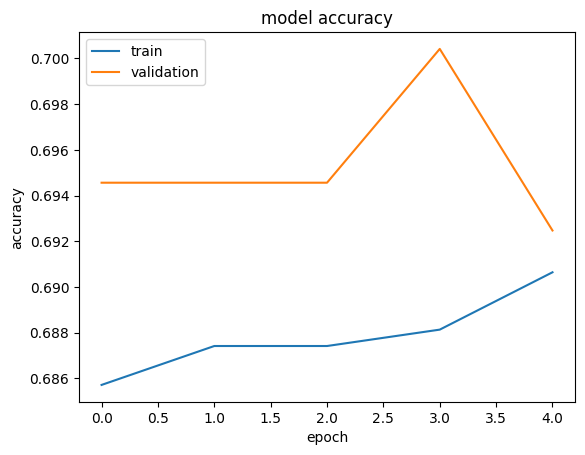

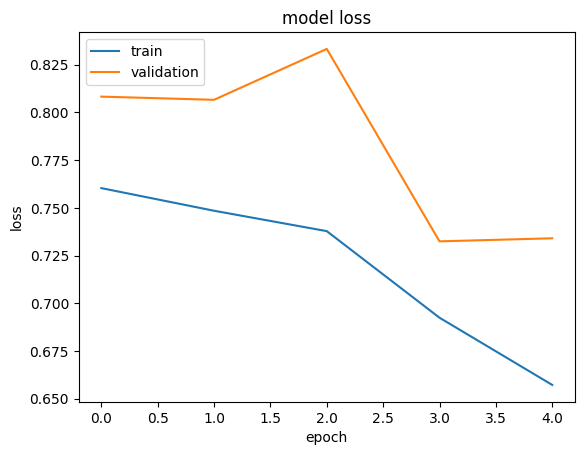

In [ ]:
#  "Accuracy"
plt.plot(m1_ori_cw_his1.history['categorical_accuracy'])
plt.plot(m1_ori_cw_his1.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(m1_ori_cw_his1.history['loss'])
plt.plot(m1_ori_cw_his1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
tf.keras.backend.clear_session()

### try second best params

In [ ]:
model1.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[
        keras.metrics.CategoricalAccuracy(), # from logits true or false?
        keras.metrics.F1Score(name="f1"), # F1 score is important because of target variable imbalance

    ],
)

In [ ]:
m1_ori_cw_his2 = model1.fit(
      x= X_train_pretensor,
      y= y_train,
      batch_size= 64,
      epochs= n_epochs,
      validation_data=(X_val_pretensor, y_val) ,
      class_weight = class_weight_dict
    )

Epoch 1/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 85s 462ms/step - categorical_accuracy: 0.6897 - f1: 0.2902 - loss: 0.7483 - val_categorical_accuracy: 0.6946 - val_f1: 0.2733 - val_loss: 0.8790
Epoch 2/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 86s 487ms/step - categorical_accuracy: 0.6921 - f1: 0.2727 - loss: 0.7384 - val_categorical_accuracy: 0.6946 - val_f1: 0.2733 - val_loss: 0.8425
Epoch 3/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 143s 493ms/step - categorical_accuracy: 0.6855 - f1: 0.2711 - loss: 0.7374 - val_categorical_accuracy: 0.6946 - val_f1: 0.2733 - val_loss: 0.8246
Epoch 4/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 80s 459ms/step - categorical_accuracy: 0.6891 - f1: 0.2720 - loss: 0.7486 - val_categorical_accuracy: 0.6946 - val_f1: 0.2733 - val_loss: 0.7757
Epoch 5/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 82s 458ms/step - categorical_accuracy: 0.6853 - f1: 0.2711 - loss: 0.7438 - val_categorical_accuracy: 0.6946 - val_f1: 0.2733 - val_loss: 0.7706


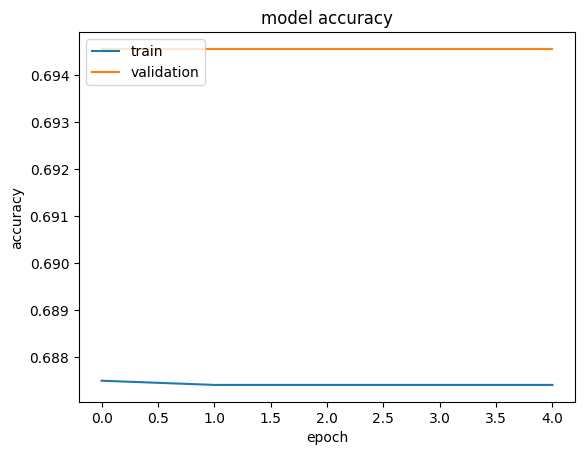

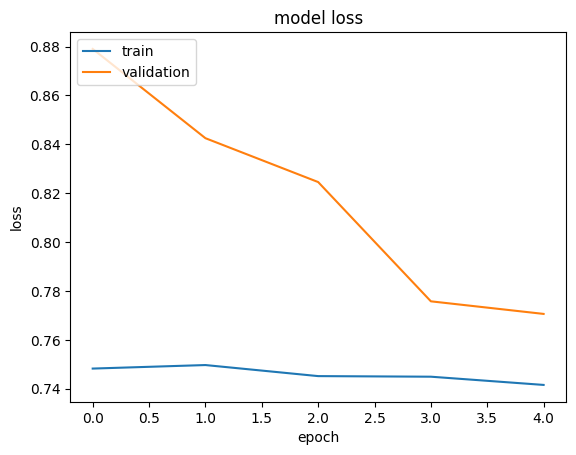

In [ ]:
#  "Accuracy"
plt.plot(m1_ori_cw_his2.history['categorical_accuracy'])
plt.plot(m1_ori_cw_his2.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(m1_ori_cw_his2.history['loss'])
plt.plot(m1_ori_cw_his2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Apply CW to Model 2 w best params

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
model2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[
        keras.metrics.CategoricalAccuracy(), # from logits true or false?
        keras.metrics.F1Score(name="f1"), # F1 score is important because of target variable imbalance

    ],
)

In [ ]:
m2_ori_cw_his1 = model2.fit(
      x= X_train_pretensor,
      y= y_train,
      batch_size= 32,
      epochs= n_epochs,
      validation_data=(X_val_pretensor, y_val),
      class_weight = class_weight_dict
    )

Epoch 1/5
349/349 ━━━━━━━━━━━━━━━━━━━━ 30s 79ms/step - categorical_accuracy: 0.6485 - f1: 0.2911 - loss: 0.7948 - val_categorical_accuracy: 0.6946 - val_f1: 0.2733 - val_loss: 0.7743
Epoch 2/5
349/349 ━━━━━━━━━━━━━━━━━━━━ 41s 80ms/step - categorical_accuracy: 0.6887 - f1: 0.2722 - loss: 0.7289 - val_categorical_accuracy: 0.6946 - val_f1: 0.2733 - val_loss: 0.7596
Epoch 3/5
349/349 ━━━━━━━━━━━━━━━━━━━━ 42s 83ms/step - categorical_accuracy: 0.6874 - f1: 0.2718 - loss: 0.7332 - val_categorical_accuracy: 0.6946 - val_f1: 0.2733 - val_loss: 0.7714
Epoch 4/5
349/349 ━━━━━━━━━━━━━━━━━━━━ 42s 86ms/step - categorical_accuracy: 0.6941 - f1: 0.2732 - loss: 0.7229 - val_categorical_accuracy: 0.6941 - val_f1: 0.2732 - val_loss: 0.7372
Epoch 5/5
349/349 ━━━━━━━━━━━━━━━━━━━━ 40s 83ms/step - categorical_accuracy: 0.6934 - f1: 0.2789 - loss: 0.6998 - val_categorical_accuracy: 0.6862 - val_f1: 0.3757 - val_loss: 0.7622


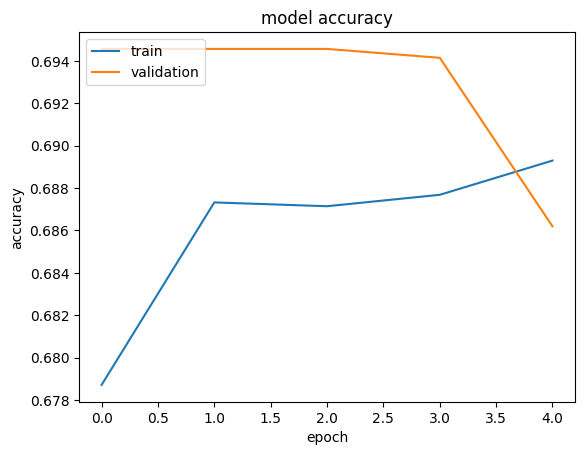

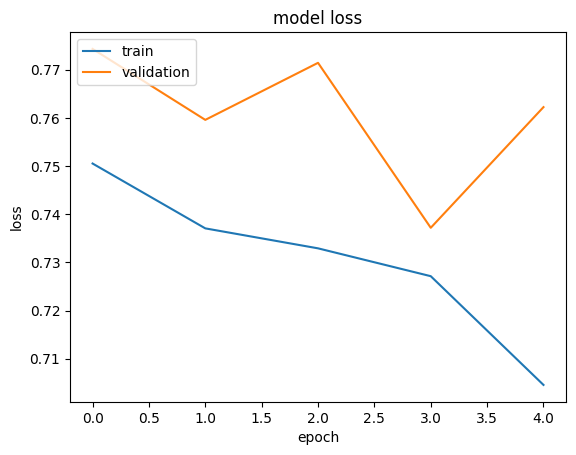

In [ ]:
#  "Accuracy"
plt.plot(m2_ori_cw_his1.history['categorical_accuracy'])
plt.plot(m2_ori_cw_his1.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(m2_ori_cw_his1.history['loss'])
plt.plot(m2_ori_cw_his1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#### Try second best params

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
m2_ori_cw_his2 = m2b32lr4_ori_his = model2.fit(
      x= X_train_pretensor,
      y= y_train,
      batch_size= 64,
      epochs= n_epochs,
      validation_data=(X_val_pretensor, y_val),
      class_weight = class_weight_dict
    )

Epoch 1/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 18s 103ms/step - categorical_accuracy: 0.6993 - f1: 0.3916 - loss: 0.6496 - val_categorical_accuracy: 0.6782 - val_f1: 0.3768 - val_loss: 0.7286
Epoch 2/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 21s 103ms/step - categorical_accuracy: 0.7029 - f1: 0.4266 - loss: 0.6285 - val_categorical_accuracy: 0.6879 - val_f1: 0.4161 - val_loss: 0.7318
Epoch 3/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 22s 113ms/step - categorical_accuracy: 0.7113 - f1: 0.4518 - loss: 0.6025 - val_categorical_accuracy: 0.6933 - val_f1: 0.4145 - val_loss: 0.6983
Epoch 4/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 18s 103ms/step - categorical_accuracy: 0.7005 - f1: 0.4601 - loss: 0.6118 - val_categorical_accuracy: 0.6774 - val_f1: 0.3958 - val_loss: 0.7302
Epoch 5/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 21s 103ms/step - categorical_accuracy: 0.7043 - f1: 0.4533 - loss: 0.6013 - val_categorical_accuracy: 0.7025 - val_f1: 0.4279 - val_loss: 0.6865


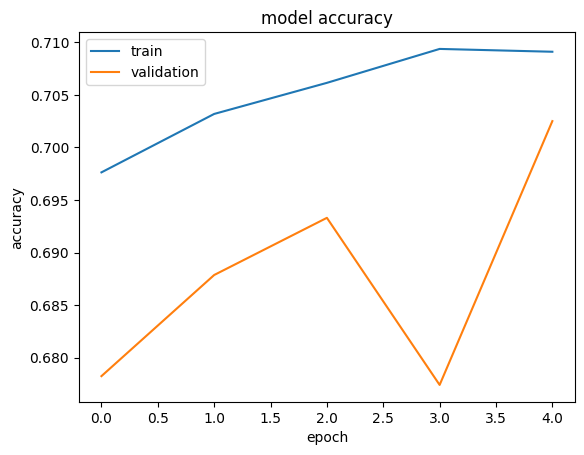

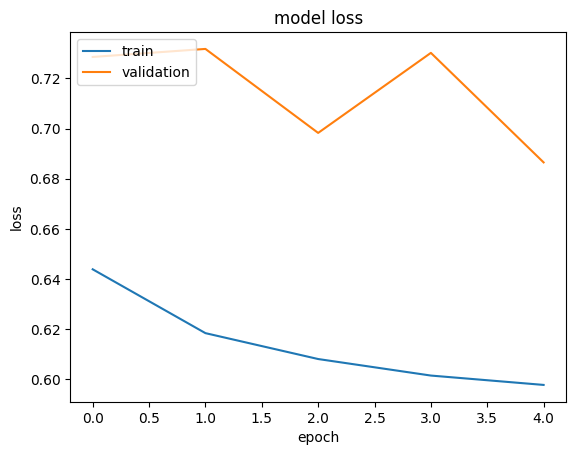

In [ ]:
#  "Accuracy"
plt.plot(m2_ori_cw_his2.history['categorical_accuracy'])
plt.plot(m2_ori_cw_his2.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(m2_ori_cw_his2.history['loss'])
plt.plot(m2_ori_cw_his2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Best params 7 epoch no cw

In [ ]:
n_epochs = 7

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
model1.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[
        keras.metrics.CategoricalAccuracy(), # from logits true or false?
        keras.metrics.F1Score(name="f1"), # F1 score is important because of target variable imbalance

    ],
)

In [ ]:
m1_ori_his = model1.fit(
      x= X_train_pretensor,
      y= y_train,
      batch_size= 32,
      epochs= n_epochs,
      validation_data=(X_val_pretensor, y_val)
    )

Epoch 1/7
349/349 ━━━━━━━━━━━━━━━━━━━━ 122s 339ms/step - categorical_accuracy: 0.6901 - f1: 0.2722 - loss: 0.7679 - val_categorical_accuracy: 0.6946 - val_f1: 0.2733 - val_loss: 0.7586
Epoch 2/7
349/349 ━━━━━━━━━━━━━━━━━━━━ 114s 327ms/step - categorical_accuracy: 0.6930 - f1: 0.2729 - loss: 0.7576 - val_categorical_accuracy: 0.6946 - val_f1: 0.2733 - val_loss: 0.7537
Epoch 3/7
349/349 ━━━━━━━━━━━━━━━━━━━━ 139s 319ms/step - categorical_accuracy: 0.6862 - f1: 0.2713 - loss: 0.7554 - val_categorical_accuracy: 0.6946 - val_f1: 0.2733 - val_loss: 0.7590
Epoch 4/7
349/349 ━━━━━━━━━━━━━━━━━━━━ 111s 318ms/step - categorical_accuracy: 0.6975 - f1: 0.2739 - loss: 0.7521 - val_categorical_accuracy: 0.6946 - val_f1: 0.2733 - val_loss: 0.7536
Epoch 5/7
349/349 ━━━━━━━━━━━━━━━━━━━━ 148s 335ms/step - categorical_accuracy: 0.6889 - f1: 0.2719 - loss: 0.7496 - val_categorical_accuracy: 0.6946 - val_f1: 0.2733 - val_loss: 0.7382
Epoch 6/7
349/349 ━━━━━━━━━━━━━━━━━━━━ 139s 328ms/step - categorical_accura

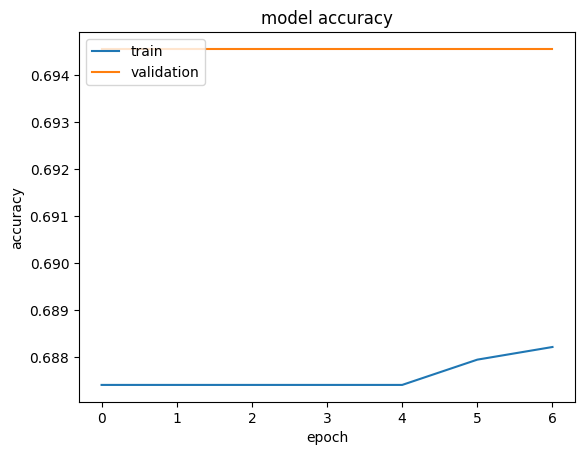

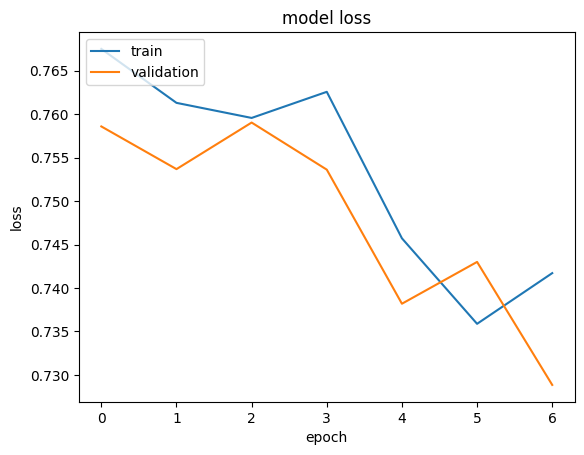

In [ ]:
#  "Accuracy"
plt.plot(m1_ori_his.history['categorical_accuracy'])
plt.plot(m1_ori_his.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(m1_ori_his.history['loss'])
plt.plot(m1_ori_his.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
model2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[
        keras.metrics.CategoricalAccuracy(), # from logits true or false?
        keras.metrics.F1Score(name="f1"), # F1 score is important because of target variable imbalance

    ],
)

In [ ]:
m2_ori_his = model2.fit(
      x= X_train_pretensor,
      y= y_train,
      batch_size= 32,
      epochs= n_epochs,
      validation_data=(X_val_pretensor, y_val)
    )

Epoch 1/7
349/349 ━━━━━━━━━━━━━━━━━━━━ 32s 85ms/step - categorical_accuracy: 0.7120 - f1: 0.4652 - loss: 0.6540 - val_categorical_accuracy: 0.6766 - val_f1: 0.4407 - val_loss: 0.6996
Epoch 2/7
349/349 ━━━━━━━━━━━━━━━━━━━━ 40s 81ms/step - categorical_accuracy: 0.7058 - f1: 0.4659 - loss: 0.6543 - val_categorical_accuracy: 0.7092 - val_f1: 0.4736 - val_loss: 0.6459
Epoch 3/7
349/349 ━━━━━━━━━━━━━━━━━━━━ 41s 81ms/step - categorical_accuracy: 0.7073 - f1: 0.4649 - loss: 0.6478 - val_categorical_accuracy: 0.7117 - val_f1: 0.4605 - val_loss: 0.6382
Epoch 4/7
349/349 ━━━━━━━━━━━━━━━━━━━━ 40s 77ms/step - categorical_accuracy: 0.7153 - f1: 0.4808 - loss: 0.6430 - val_categorical_accuracy: 0.7067 - val_f1: 0.4751 - val_loss: 0.6471
Epoch 5/7
349/349 ━━━━━━━━━━━━━━━━━━━━ 27s 78ms/step - categorical_accuracy: 0.7205 - f1: 0.4848 - loss: 0.6277 - val_categorical_accuracy: 0.7226 - val_f1: 0.4827 - val_loss: 0.6300
Epoch 6/7
349/349 ━━━━━━━━━━━━━━━━━━━━ 43s 84ms/step - categorical_accuracy: 0.7128 -

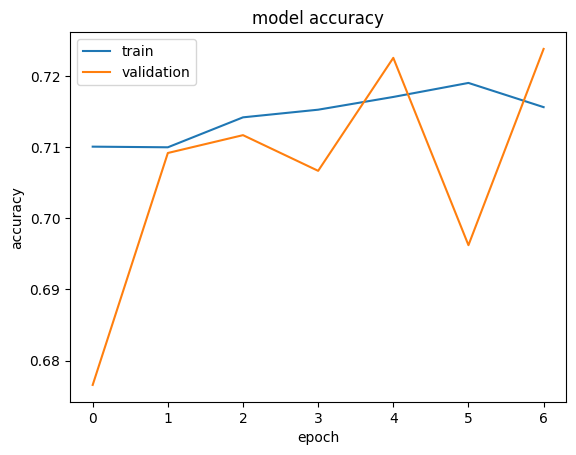

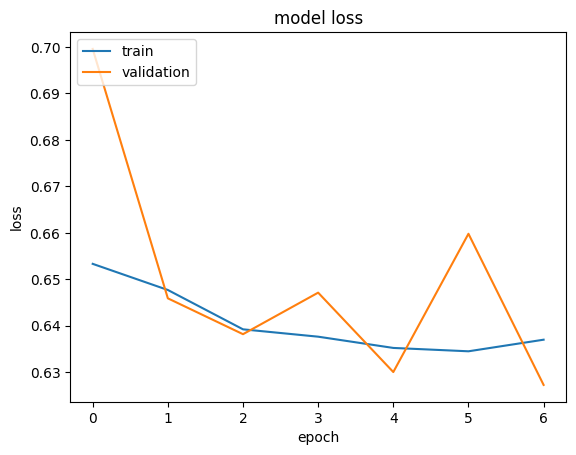

In [ ]:
#  "Accuracy"
plt.plot(m2_ori_his.history['categorical_accuracy'])
plt.plot(m2_ori_his.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(m2_ori_his.history['loss'])
plt.plot(m2_ori_his.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Apply Resample

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to generate synthetic samples
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_pretensor, y_train)

In [ ]:
tf.keras.backend.clear_session()

### Model 1

In [ ]:
m1_rs_his = model1.fit(
      x= X_train_resampled,
      y= y_train_resampled,
      batch_size= 32,
      epochs= 5,
      validation_data=(X_val_pretensor, y_val)
    )

Epoch 1/5
719/719 ━━━━━━━━━━━━━━━━━━━━ 260s 360ms/step - categorical_accuracy: 0.3818 - f1: 0.3568 - loss: 1.0790 - val_categorical_accuracy: 0.6950 - val_f1: 0.3216 - val_loss: 0.9690
Epoch 2/5
719/719 ━━━━━━━━━━━━━━━━━━━━ 216s 300ms/step - categorical_accuracy: 0.4084 - f1: 0.3773 - loss: 1.0603 - val_categorical_accuracy: 0.6757 - val_f1: 0.3664 - val_loss: 0.9764
Epoch 3/5
719/719 ━━━━━━━━━━━━━━━━━━━━ 239s 332ms/step - categorical_accuracy: 0.4850 - f1: 0.4545 - loss: 0.9907 - val_categorical_accuracy: 0.6841 - val_f1: 0.3752 - val_loss: 0.9394
Epoch 4/5
719/719 ━━━━━━━━━━━━━━━━━━━━ 272s 346ms/step - categorical_accuracy: 0.4692 - f1: 0.4266 - loss: 0.9932 - val_categorical_accuracy: 0.5674 - val_f1: 0.3347 - val_loss: 1.0287
Epoch 5/5
719/719 ━━━━━━━━━━━━━━━━━━━━ 222s 308ms/step - categorical_accuracy: 0.3610 - f1: 0.3569 - loss: 1.0770 - val_categorical_accuracy: 0.6958 - val_f1: 0.2955 - val_loss: 1.0139


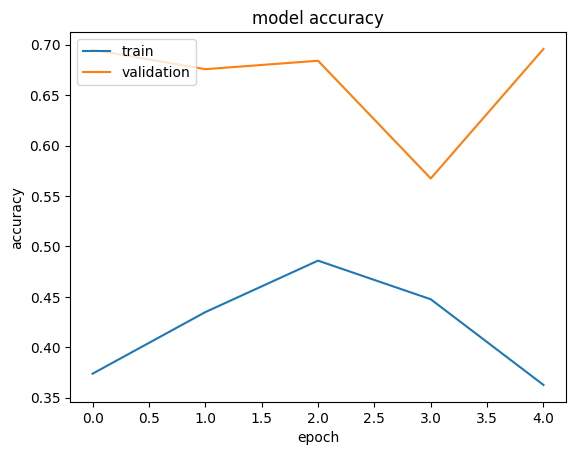

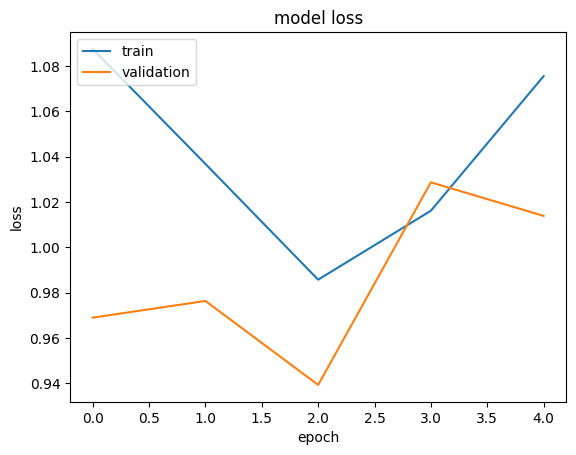

In [ ]:
#  "Accuracy"
plt.plot(m1_rs_his.history['categorical_accuracy'])
plt.plot(m1_rs_his.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(m1_rs_his.history['loss'])
plt.plot(m1_rs_his.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# "F1"
plt.plot(m1_rs_his.history['f1_score'])
plt.plot(m1_rs_his.history['val_f1_score'])
plt.title('model F1')
plt.ylabel('F1')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Model 2

In [ ]:
m2_rs_his = model2.fit(
      x= X_train_resampled,
      y= y_train_resampled,
      batch_size= 32,
      epochs= 5,
      validation_data=(X_val_pretensor, y_val)
    )

Epoch 1/5
719/719 ━━━━━━━━━━━━━━━━━━━━ 56s 78ms/step - categorical_accuracy: 0.3353 - f1: 0.3245 - loss: 1.1015 - val_categorical_accuracy: 0.6946 - val_f1: 0.2733 - val_loss: 1.0886
Epoch 2/5
719/719 ━━━━━━━━━━━━━━━━━━━━ 57s 79ms/step - categorical_accuracy: 0.3278 - f1: 0.3206 - loss: 1.0997 - val_categorical_accuracy: 0.6946 - val_f1: 0.2733 - val_loss: 1.0477
Epoch 3/5
719/719 ━━━━━━━━━━━━━━━━━━━━ 83s 80ms/step - categorical_accuracy: 0.3284 - f1: 0.3183 - loss: 1.0996 - val_categorical_accuracy: 0.2607 - val_f1: 0.1378 - val_loss: 1.0778
Epoch 4/5
719/719 ━━━━━━━━━━━━━━━━━━━━ 80s 78ms/step - categorical_accuracy: 0.3333 - f1: 0.2920 - loss: 1.0994 - val_categorical_accuracy: 0.0448 - val_f1: 0.0286 - val_loss: 1.1217
Epoch 5/5
719/719 ━━━━━━━━━━━━━━━━━━━━ 87s 85ms/step - categorical_accuracy: 0.3345 - f1: 0.3036 - loss: 1.0989 - val_categorical_accuracy: 0.6946 - val_f1: 0.2733 - val_loss: 1.0957


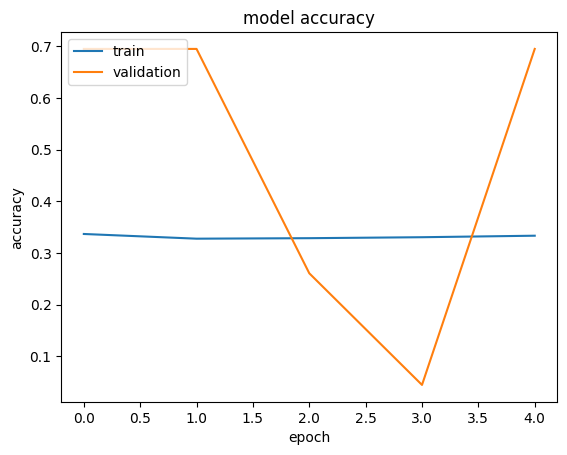

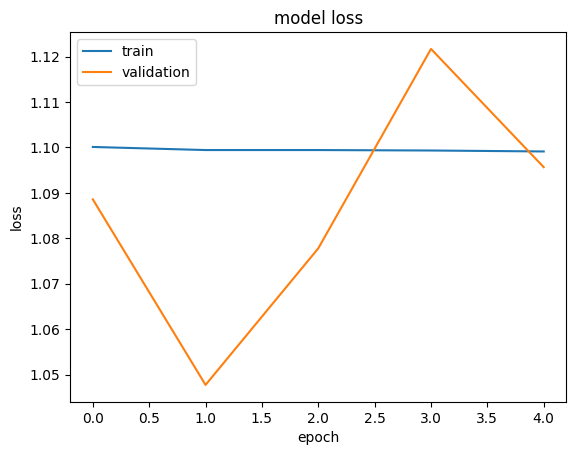

In [ ]:
#  "Accuracy"
plt.plot(m2_rs_his.history['categorical_accuracy'])
plt.plot(m2_rs_his.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(m2_rs_his.history['loss'])
plt.plot(m2_rs_his.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Remove Dropout Layer of Model 1 and one conv + maxpooling and  rm one hidden dense size 128 and continue

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to generate synthetic samples
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_pretensor, y_train)

In [ ]:
tf.keras.backend.clear_session()

## Define New Model

In [ ]:
model11 = keras.Sequential([
    keras.Input(shape=(None, 1)),
    keras.layers.SimpleRNN(256,activation = "tanh"),
    keras.layers.Reshape((-1, 1) ),
    keras.layers.Conv1D(128, 4, activation='relu'),
    keras.layers.MaxPooling1D(pool_size=4, strides=2, padding="same"),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(3, activation="softmax")

])

In [ ]:
model11.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[
        keras.metrics.CategoricalAccuracy(), # from logits true or false?
        keras.metrics.F1Score(name="f1"), # F1 score is important because of target variable imbalance

    ],
)

In [ ]:
model11.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 256)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 256, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 253, 128)            │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 127, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16256)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       1,040,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,107,331 (4.22 MB)

 Trainable params: 1,107,331 (4.22 MB)

 Non-trainable params: 0 (0.00 B)

### Test new model on 5 epoch

In [ ]:
m11_rs_his_test = model11.fit(
      x= X_train_resampled,
      y= y_train_resampled,
      batch_size= 32,
      epochs= 5,
      validation_data=(X_val_pretensor, y_val)
    )

Epoch 1/5
719/719 ━━━━━━━━━━━━━━━━━━━━ 200s 276ms/step - categorical_accuracy: 0.4148 - f1: 0.4096 - loss: 1.0323 - val_categorical_accuracy: 0.4699 - val_f1: 0.4404 - val_loss: 0.8924
Epoch 2/5
719/719 ━━━━━━━━━━━━━━━━━━━━ 211s 288ms/step - categorical_accuracy: 0.6176 - f1: 0.6001 - loss: 0.7536 - val_categorical_accuracy: 0.5159 - val_f1: 0.4514 - val_loss: 0.9004
Epoch 3/5
719/719 ━━━━━━━━━━━━━━━━━━━━ 268s 296ms/step - categorical_accuracy: 0.6223 - f1: 0.6056 - loss: 0.7330 - val_categorical_accuracy: 0.6619 - val_f1: 0.4764 - val_loss: 0.7938
Epoch 4/5
719/719 ━━━━━━━━━━━━━━━━━━━━ 216s 300ms/step - categorical_accuracy: 0.6406 - f1: 0.6202 - loss: 0.7177 - val_categorical_accuracy: 0.5987 - val_f1: 0.4603 - val_loss: 0.8605
Epoch 5/5
719/719 ━━━━━━━━━━━━━━━━━━━━ 309s 366ms/step - categorical_accuracy: 0.6453 - f1: 0.6318 - loss: 0.7136 - val_categorical_accuracy: 0.6126 - val_f1: 0.5259 - val_loss: 0.7694


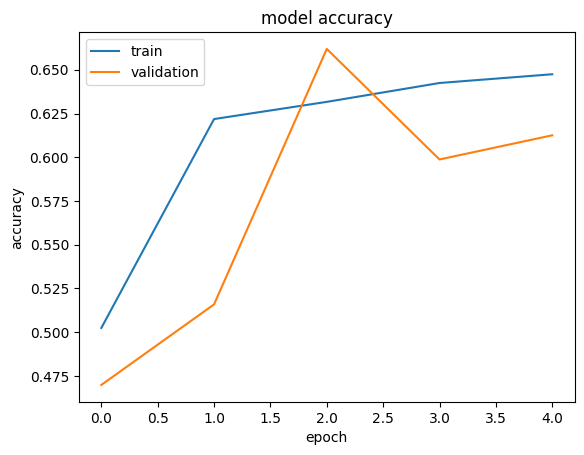

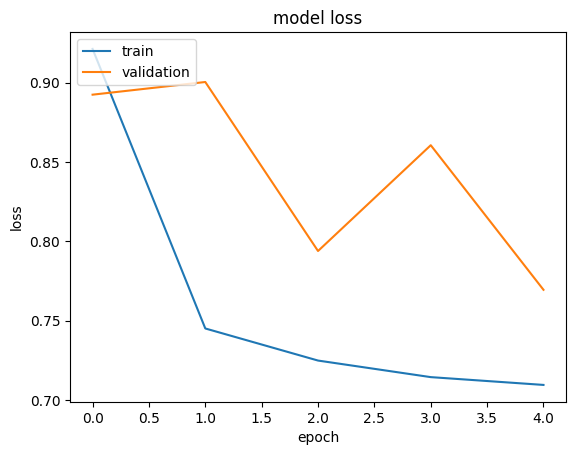

In [ ]:
#  "Accuracy"
plt.plot(m11_rs_his_test.history['categorical_accuracy'])
plt.plot(m11_rs_his_test.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(m11_rs_his_test.history['loss'])
plt.plot(m11_rs_his_test.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Try new model with lr scheduler and 30 epoch

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
def scheduler(epoch, lr):
     if epoch < 10:
         return lr
     elif epoch < 15:
         return lr * tf.math.exp(-0.1).numpy()
     elif epoch < 20:
         return lr * tf.math.exp(-0.2).numpy()
     else:
         return lr * tf.math.exp(-0.3).numpy()
callback1 = keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
m11_rs_his_sched1 = model11.fit(
      x= X_train_resampled,
      y= y_train_resampled,
      batch_size= 32,
      epochs= 30,
      validation_data=(X_val_pretensor, y_val),
      callbacks = callback1
    )

Epoch 1/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 203s 279ms/step - categorical_accuracy: 0.4210 - f1: 0.4146 - loss: 1.0301 - val_categorical_accuracy: 0.6494 - val_f1: 0.4010 - val_loss: 0.8636 - learning_rate: 1.0000e-04
Epoch 2/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 197s 272ms/step - categorical_accuracy: 0.5989 - f1: 0.5723 - loss: 0.7686 - val_categorical_accuracy: 0.4690 - val_f1: 0.4392 - val_loss: 0.9564 - learning_rate: 1.0000e-04
Epoch 3/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 197s 266ms/step - categorical_accuracy: 0.6381 - f1: 0.6229 - loss: 0.7199 - val_categorical_accuracy: 0.6414 - val_f1: 0.4738 - val_loss: 0.8019 - learning_rate: 1.0000e-04
Epoch 4/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 199s 261ms/step - categorical_accuracy: 0.6486 - f1: 0.6345 - loss: 0.7080 - val_categorical_accuracy: 0.6054 - val_f1: 0.5082 - val_loss: 0.7599 - learning_rate: 1.0000e-04
Epoch 5/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 202s 261ms/step - categorical_accuracy: 0.6602 - f1: 0.6438 - loss: 0.6847 - val_categorical_accuracy: 0

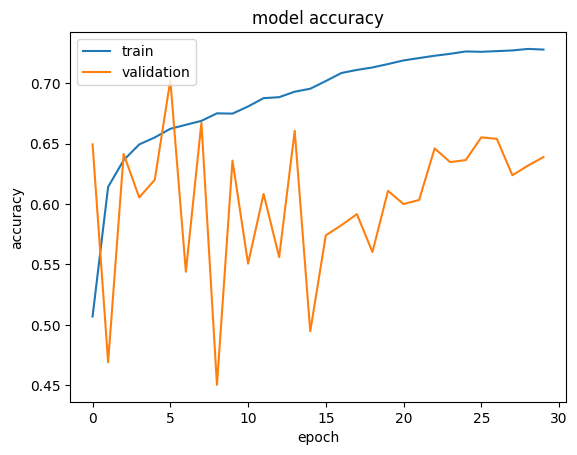

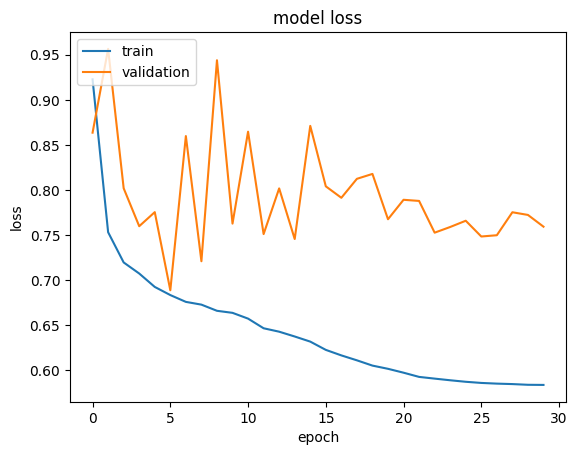

In [ ]:
#  "Accuracy"
plt.plot(m11_rs_his_sched1.history['categorical_accuracy'])
plt.plot(m11_rs_his_sched1.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(m11_rs_his_sched1.history['loss'])
plt.plot(m11_rs_his_sched1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
n_epochs = 60

In [ ]:
def scheduler(epoch, lr):
     if epoch < 10:
         return lr
     elif epoch < 15:
         return lr * tf.math.exp(-0.1).numpy()
     elif epoch < 20:
         return lr * tf.math.exp(-0.2).numpy()
     elif epoch < 25:
         return lr * tf.math.exp(-0.3).numpy()
     elif epoch < 30:
         return lr * tf.math.exp(-0.4).numpy()
     elif epoch < 35:
         return lr * tf.math.exp(-0.5).numpy()
     elif epoch < 40:
         return lr * tf.math.exp(-0.6).numpy()
     elif epoch < 45:
         return lr * tf.math.exp(-0.7).numpy()
     elif epoch < 50:
         return lr * tf.math.exp(-0.8).numpy()
     else:
         return lr * tf.math.exp(-0.9).numpy()

callback2 = keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
m11_rs_his_sched2 = model11.fit(
      x= X_train_resampled,
      y= y_train_resampled,
      batch_size= 32,
      epochs= n_epochs,
      validation_data=(X_val_pretensor, y_val),
      callbacks = callback2
    )

Epoch 1/60
719/719 ━━━━━━━━━━━━━━━━━━━━ 34s 43ms/step - categorical_accuracy: 0.4393 - f1: 0.4273 - loss: 1.0103 - val_categorical_accuracy: 0.5548 - val_f1: 0.4544 - val_loss: 0.8428 - learning_rate: 1.0000e-04
Epoch 2/60
719/719 ━━━━━━━━━━━━━━━━━━━━ 28s 39ms/step - categorical_accuracy: 0.5968 - f1: 0.5749 - loss: 0.7889 - val_categorical_accuracy: 0.4690 - val_f1: 0.4171 - val_loss: 0.9321 - learning_rate: 1.0000e-04
Epoch 3/60
719/719 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - categorical_accuracy: 0.6183 - f1: 0.6001 - loss: 0.7558 - val_categorical_accuracy: 0.4289 - val_f1: 0.3975 - val_loss: 0.9816 - learning_rate: 1.0000e-04
Epoch 4/60
719/719 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - categorical_accuracy: 0.6305 - f1: 0.6145 - loss: 0.7438 - val_categorical_accuracy: 0.5197 - val_f1: 0.4132 - val_loss: 1.0003 - learning_rate: 1.0000e-04
Epoch 5/60
719/719 ━━━━━━━━━━━━━━━━━━━━ 28s 40ms/step - categorical_accuracy: 0.6385 - f1: 0.6244 - loss: 0.7293 - val_categorical_accuracy: 0.5628 - va

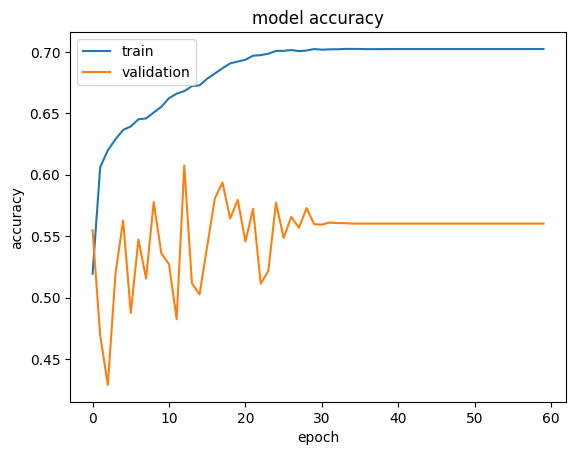

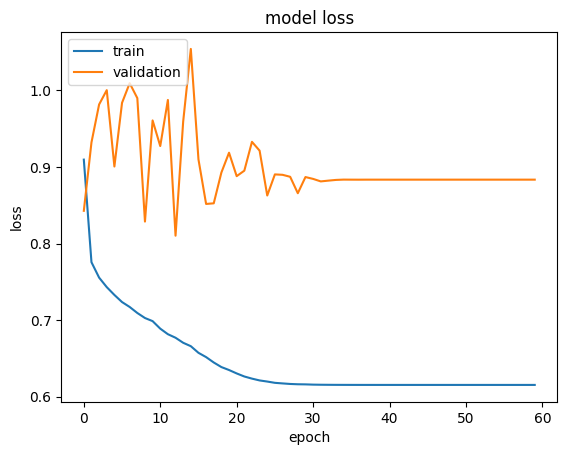

In [ ]:
#  "Accuracy"
plt.plot(m11_rs_his_sched2.history['categorical_accuracy'])
plt.plot(m11_rs_his_sched2.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(m11_rs_his_sched2.history['loss'])
plt.plot(m11_rs_his_sched2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Test model

In [ ]:
model11.test_on_batch(X_test_pretensor, y_test)

[array(0.80980116, dtype=float32),
 array(0.60167366, dtype=float32),
 array([0.30259845, 0.43407232, 0.7373753 ], dtype=float32)]

In [ ]:
loss, accuracy, f1 = model11.evaluate(X_test_pretensor, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Test F1:", np.mean(f1))

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - categorical_accuracy: 0.6352 - f1: 0.5213 - loss: 0.7528
Test Loss: 0.7361457347869873
Test Accuracy: 0.6430962085723877
Test F1: 0.5180864
